ИТОГ =  0.9648
[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.99]


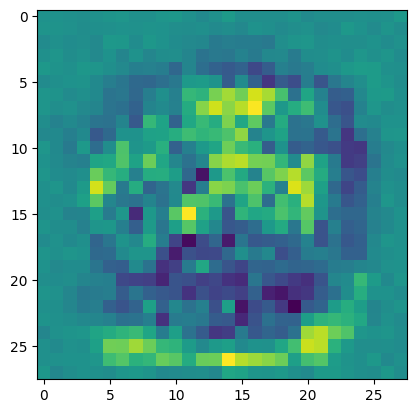

In [11]:
import numpy
# scipy.special for the sigmoid function expit(), and its inverse logit()
import scipy.special
# library for plotting arrays
import matplotlib.pyplot


# neural network class definition
class neuralNetwork:
    
    
    # initialise the neural network
    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate):
        # set number of nodes in each input, hidden, output layer
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes
        
        # link weight matrices, wih and who
        # weights inside the arrays are w_i_j, where link is from node i to node j in the next layer
        # w11 w21
        # w12 w22 etc 
        self.wih = numpy.random.normal(0.0, pow(self.inodes, -0.5), (self.hnodes, self.inodes))
        self.who = numpy.random.normal(0.0, pow(self.hnodes, -0.5), (self.onodes, self.hnodes))

        # learning rate
        self.lr = learningrate
        
        # activation function is the sigmoid function
        self.activation_function = lambda x: scipy.special.expit(x)
        self.inverse_activation_function = lambda x: scipy.special.logit(x)
        
        pass

    
    # train the neural network
    def train(self, inputs_list, targets_list):
        # convert inputs list to 2d array
        inputs = numpy.array(inputs_list, ndmin=2).T
        targets = numpy.array(targets_list, ndmin=2).T
        
        # calculate signals into hidden layer
        hidden_inputs = numpy.dot(self.wih, inputs)
        # calculate the signals emerging from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # calculate signals into final output layer
        final_inputs = numpy.dot(self.who, hidden_outputs)
        # calculate the signals emerging from final output layer
        final_outputs = self.activation_function(final_inputs)
        
        # output layer error is the (target - actual)
        output_errors = targets - final_outputs
        # hidden layer error is the output_errors, split by weights, recombined at hidden nodes
        hidden_errors = numpy.dot(self.who.T, output_errors) 
        
        # update the weights for the links between the hidden and output layers
        self.who += self.lr * numpy.dot((output_errors * final_outputs * (1.0 - final_outputs)), numpy.transpose(hidden_outputs))
        
        # update the weights for the links between the input and hidden layers
        self.wih += self.lr * numpy.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), numpy.transpose(inputs))
        
        pass

    
    # query the neural network
    def query(self, inputs_list):
        # convert inputs list to 2d array
        inputs = numpy.array(inputs_list, ndmin=2).T
        
        # calculate signals into hidden layer
        hidden_inputs = numpy.dot(self.wih, inputs)
        # calculate the signals emerging from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # calculate signals into final output layer
        final_inputs = numpy.dot(self.who, hidden_outputs)
        # calculate the signals emerging from final output layer
        final_outputs = self.activation_function(final_inputs)
        
        return final_outputs
    
    # обратным запросом к нейронной сети
 # мы будем использовать одну и ту же терминологию для каждого элемента,
# например, target - это значения справа от сети, хотя и используемые в качестве входных данных
 # например, hidden_output - это сигнал справа от средних узлов
    def backquery(self, targets_list):
        #преобразовать список целевых объектов в вертикальный массив
        final_outputs = numpy.array(targets_list, ndmin=2).T
        
        # вычислите сигнал для конечного выходного слоя
        final_inputs = self.inverse_activation_function(final_outputs)

        # вычислите сигнал из скрытого слоя
        hidden_outputs = numpy.dot(self.who.T, final_inputs)
        # уменьшите их значение с 0,01 до 0,99
        hidden_outputs -= numpy.min(hidden_outputs)
        hidden_outputs /= numpy.max(hidden_outputs)
        hidden_outputs *= 0.98
        hidden_outputs += 0.01
        
        # вычислите сигнал для скрытого слоя
        hidden_inputs = self.inverse_activation_function(hidden_outputs)
        
        # вычислите сигнал из входного слоя
        inputs = numpy.dot(self.wih.T, hidden_inputs)
        # уменьшите их значение с 0,01 до 0,99
        inputs -= numpy.min(inputs)
        inputs /= numpy.max(inputs)
        inputs *= 0.98
        inputs += 0.01
        
        return inputs
    



input_nodes = 784
hidden_nodes = 100
output_nodes = 10

# learning rate
learning_rate = 0.1

# create instance of neural network
n = neuralNetwork(input_nodes,hidden_nodes,output_nodes, learning_rate)





# загрузите CSV-файл обучающих данных mnist в виде списка
training_data_file = open("mnist_train.csv", 'r')
training_data_list = training_data_file.readlines()
training_data_file.close()





# train the neural network

# epochs is the number of times the training data set is used for training
epochs = 5

for e in range(epochs):
    # go through all records in the training data set
    for record in training_data_list:
        # split the record by the ',' commas
        all_values = record.split(',')
        # scale and shift the inputs
        inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
        # create the target output values (all 0.01, except the desired label which is 0.99)
        targets = numpy.zeros(output_nodes) + 0.01
        # all_values[0] is the target label for this record
        targets[int(all_values[0])] = 0.99
        n.train(inputs, targets)
        pass
    pass





# load the mnist test data CSV file into a list
test_data_file = open("mnist_test.csv", 'r')
test_data_list = test_data_file.readlines()
test_data_file.close()



# протестировать нейронную сеть

# система показателей эффективности работы сети, изначально пустая
scorecard = []
# просмотреть все записи в наборе тестовых данных
for record in test_data_list:
   # разделите запись запятыми ","
    all_values = record.split(',')
    # правильный ответ - это первое значение
    correct_label = int(all_values[0])
  # масштабирование и сдвиг входных данных
    inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
  # запросить сеть
    outputs = n.query(inputs)
    # индекс с наибольшим значением соответствует метке
    label = numpy.argmax(outputs)
    # добавить правильное или неправильное дополнение к списку
    if (label == correct_label):
        # ответ сети совпадает с правильным ответом, добавьте 1 в оценочную таблицу.
        scorecard.append(1)
    else:
        # ответ сети не соответствует правильному ответу, добавьте 0 в систему показателей.
        scorecard.append(0)
        pass
    
    pass





# calculate the performance score, the fraction of correct answers
scorecard_array = numpy.asarray(scorecard)
print ("ИТОГ = ", scorecard_array.sum() / scorecard_array.size)



# запустите сеть в обратном направлении, получив метку, посмотрите, какое изображение она выдает

# метка для тестирования
label = 9
# создайте выходные сигналы для этой метки
targets = numpy.zeros(output_nodes) + 0.01
# all_values[0] - целевая метка для этой записи
targets[label] = 0.99
print(targets)

# получение данных изображения
image_data = n.backquery(targets)

# построение графических данных
matplotlib.pyplot.imshow(image_data.reshape(28,28), interpolation='None') #cmap='Greys', interpolation='None')